In [1]:
%LOAD tidb user=root host=127.0.0.1 port=4000 db=Chinook

In [2]:
select * from mysql.tidb;

VARIABLE_NAME,VARIABLE_VALUE,COMMENT
bootstrapped,True,Bootstrap flag. Do not delete.
tidb_server_version,59,Bootstrap version. Do not delete.
system_tz,Asia/Singapore,TiDB Global System Timezone.
new_collation_enabled,False,If the new collations are enabled. Do not edit it.
tikv_gc_leader_uuid,5dc12048c340001,Current GC worker leader UUID. (DO NOT EDIT)
tikv_gc_leader_desc,"host:C02CT123MD6R, pid:26185, start at 2021-01-15 13:25:07.983714 +0800 +08 m=+3.268753608",Host name and pid of current GC leader. (DO NOT EDIT)
tikv_gc_leader_lease,20210116-00:35:48 +0800,Current GC worker leader lease. (DO NOT EDIT)
tikv_gc_enable,true,Current GC enable status
tikv_gc_run_interval,10m0s,"GC run interval, at least 10m, in Go format."
tikv_gc_life_time,10m0s,"All versions within life time will not be collected by GC, at least 10m, in Go format."


In [3]:
select at.Name as name, 
       sum(il.quantity) as total_quantity, 
       sum(il.quantity*il.unitPrice) as total_sales 
from track t
     inner join invoiceLine il on il.TrackId=t.TrackId
     inner join album a on a.AlbumId=t.AlbumId
     inner join artist at on at.ArtistId=a.ArtistId
group by 1
order by total_sales desc
limit 10;

name,total_quantity,total_sales
Iron Maiden,140,138.6
U2,107,105.93
Metallica,91,90.09
Led Zeppelin,87,86.13
Lost,41,81.59
The Office,25,49.75
Os Paralamas Do Sucesso,45,44.55
Deep Purple,44,43.56
Faith No More,42,41.58
Eric Clapton,40,39.6


# Data Visualization

## bar chart
Visualizing a discrete, categorical data attribute 

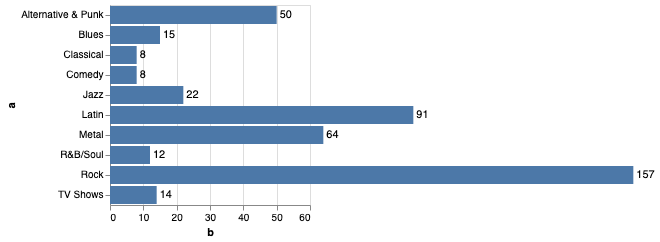

In [4]:
%VEGA-LITE specs/layer_bar_labels.vl.json 
SELECT 
    g.Name as a, 
    SUM(il.Quantity) as b, 
    ROUND((CAST(SUM(il.Quantity) as float) / (SELECT 
        SUM(Quantity) total
    FROM Chinook.InvoiceLine il
    INNER JOIN Chinook.Invoice i ON i.InvoiceId = il.InvoiceId
    WHERE i.BillingCountry = 'USA')) * 100, 2) percent_sold 
FROM Chinook.InvoiceLine il
INNER JOIN Chinook.Invoice i ON i.InvoiceId = il.InvoiceId 
INNER JOIN Chinook.Track t ON il.TrackId = t.TrackId 
INNER JOIN Chinook.Genre g ON t.GenreId = g.GenreId 
WHERE i.BillingCountry = 'USA' 
GROUP BY 1 
ORDER BY 2 DESC
LIMIT 10

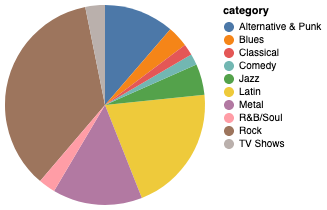

In [5]:
%VEGA-LITE specs/arc_pie.vl.json 
SELECT 
    g.Name as category, 
    SUM(il.Quantity) as b, 
    ROUND((CAST(SUM(il.Quantity) as float) / (SELECT 
        SUM(Quantity) total
    FROM Chinook.InvoiceLine il
    INNER JOIN Chinook.Invoice i ON i.InvoiceId = il.InvoiceId
    WHERE i.BillingCountry = 'USA')) * 100, 2) value 
FROM Chinook.InvoiceLine il
INNER JOIN Chinook.Invoice i ON i.InvoiceId = il.InvoiceId 
INNER JOIN Chinook.Track t ON il.TrackId = t.TrackId 
INNER JOIN Chinook.Genre g ON t.GenreId = g.GenreId 
WHERE i.BillingCountry = 'USA' 
GROUP BY 1 
ORDER BY 2 DESC
LIMIT 10

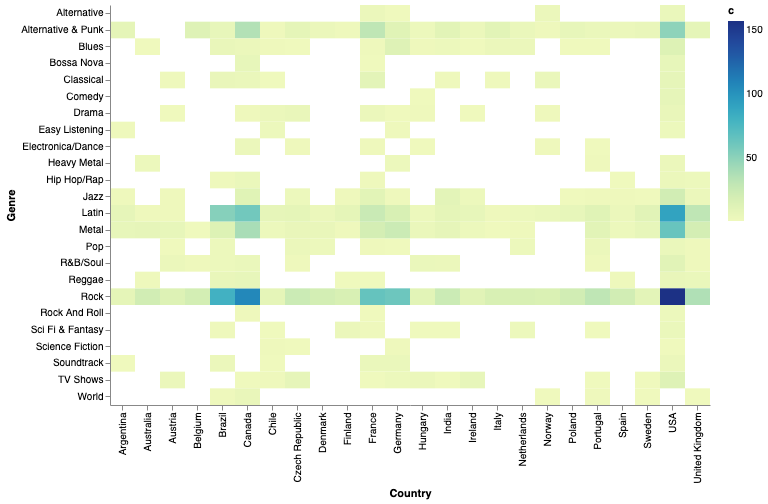

In [6]:
%VEGA-LITE rect_category_heatmap.vl.json 
select i.BillingCountry as Country, g.name as Genre, count(1) as c
from invoice i 
    inner join InvoiceLine il on i.InvoiceId=il.InvoiceId 
    inner join track t on t.TrackId=il.TrackId 
    inner join genre g on g.GenreId=t.GenreId
group by 1,2